In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader as web
import datetime as dt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn import svm
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, RandomForestClassifier
from sklearn.metrics import mean_squared_error, r2_score, classification_report, confusion_matrix, precision_score, recall_score
from sklearn.cluster import KMeans
import xgboost as xgb

import warnings
warnings.filterwarnings("ignore", module="statsmodels")
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping

import textwrap
import matplotlib.patches as mpatches

In [ ]:
df = pd.read_csv('/content/USvideos.csv')
all_category = pd.read_json('/content/US_category_id.json')
for i in range(3):
  print(all_category['items'][i])

{'kind': 'youtube#videoCategory', 'etag': '"m2yskBQFythfE4irbTIeOgYYfBU/Xy1mB4_yLrHy_BmKmPBggty2mZQ"', 'id': '1', 'snippet': {'channelId': 'UCBR8-60-B28hp2BmDPdntcQ', 'title': 'Film & Animation', 'assignable': True}}
{'kind': 'youtube#videoCategory', 'etag': '"m2yskBQFythfE4irbTIeOgYYfBU/UZ1oLIIz2dxIhO45ZTFR3a3NyTA"', 'id': '2', 'snippet': {'channelId': 'UCBR8-60-B28hp2BmDPdntcQ', 'title': 'Autos & Vehicles', 'assignable': True}}
{'kind': 'youtube#videoCategory', 'etag': '"m2yskBQFythfE4irbTIeOgYYfBU/nqRIq97-xe5XRZTxbknKFVe5Lmg"', 'id': '10', 'snippet': {'channelId': 'UCBR8-60-B28hp2BmDPdntcQ', 'title': 'Music', 'assignable': True}}


# LSTM Predictions (for recommendation purposes)

In [ ]:
# LSTM predictions used for generating recommendations
def df_to_X_y(df, window_size=5):
  df2 = df.set_index('days_since_start', inplace=False)
  df_as_np = df2.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = df_as_np[i:i+window_size]
    X.append(row)
    label = df_as_np[i+window_size]
    y.append(label)
  return np.array(X), np.array(y)

X = df[['likes', 'dislikes', 'comment_count']]
y = df[['views']].values.ravel()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
regr_rf_final = RandomForestRegressor(random_state=42)
regr_rf_final.fit(X_train, y_train.reshape(-1, 1))
y_pred_rf_final = regr_rf_final.predict(X)

normalized_error = (y - y_pred_rf_final) / np.sqrt(mean_squared_error(y, y_pred_rf_final))
outliers = np.abs(normalized_error) > 1

# Preprocess data for time-series analysis
df2 = pd.read_csv('/content/USvideos.csv')
df2 = df2[df2['video_error_or_removed'] == False].copy()
df2 = df2[~outliers]
data = df2

# Convert trending_date from 'yy.dd.mm' format to datetime
data['trending_date'] = pd.to_datetime(data['trending_date'], format='%y.%d.%m')
data['trending_year'] = data['trending_date'].dt.year
data['trending_month'] = data['trending_date'].dt.month

# Define reference date using datetime
reference_date = df['trending_date'].min()

# Compute days since reference date
data['days_since_start'] = (data['trending_date'] - reference_date).dt.days

# for the purpose of accessing categories
combined_df = df.sort_values('category_id', inplace=False).groupby(['category_id', 'category']).agg({'views':['sum', 'mean']}).reset_index()

lstm_future_predictions = {}
window_size=5
for i in range(4):
  for j in range(4):
    id = i * 4 + j
    cat_id, cat_name = combined_df.iloc[id, :]['category_id'].values[0], combined_df.iloc[id, :]['category'].values[0]
    cur_data = data[(data['category_id'] == cat_id)].reset_index()

    views_num_days = pd.pivot_table(cur_data,index='days_since_start', values='views',aggfunc='sum').reset_index().sort_values(by='views')
    views_num_days = views_num_days.sort_values(by='days_since_start')

    scaler_X = MinMaxScaler(feature_range=(0, 1))
    scaler_Y = MinMaxScaler(feature_range=(0, 1))

    X, y = df_to_X_y(views_num_days, window_size)
    train_size = int(len(X) * 0.8)
    X_train, Y_train = X[:train_size], y[:train_size]
    X_test, Y_test = X[train_size:], y[train_size:]

    # Reshape X_train and X_test to 2D for scaling
    X_train_shape = X_train.shape
    X_train_2D = X_train.reshape(X_train_shape[0], -1)

    X_test_shape = X_test.shape
    X_test_2D = X_test.reshape(X_test_shape[0], -1)

    # Scale the 2D arrays
    X_train_scaled_2D = scaler_X.fit_transform(X_train_2D)
    X_test_scaled_2D = scaler_X.transform(X_test_2D)

    # Reshape the scaled data back to 3D for the LSTM model
    X_train_scaled = X_train_scaled_2D.reshape(X_train_shape)
    X_test_scaled = X_test_scaled_2D.reshape(X_test_shape)

    # Scale the target variable
    Y_train_scaled = scaler_Y.fit_transform(Y_train.reshape(-1, 1))
    Y_test_scaled = scaler_Y.transform(Y_test.reshape(-1, 1))

    model = Sequential()
    model.add(InputLayer((window_size, 1)))
    model.add(LSTM(64))
    model.add(Dense(8, 'relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')

    model.fit(X_train_scaled, Y_train_scaled, validation_split=0.15, epochs=50, batch_size=16, verbose=0)

    predictions_scaled = model.predict(X_test_scaled)
    predictions = scaler_Y.inverse_transform(predictions_scaled)


    lstm_future_predictions[cat_name] = predictions

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 298ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


# Data Preprocessing

In [25]:
# Reomve error videos
df = df[df['video_error_or_removed'] == False].copy()

# Identify rows with '#NAME?' video_id (missing video_id)
problem_rows = df[df['video_id'] == '#NAME?']

# Create a new identifier for these rows
new_ids = problem_rows.apply(lambda row: f"{row['title']}_{row['category_id']}", axis=1)

# Map category names
category_ids = {int(all_category['items'][i]['id']):all_category['items'][i]['snippet']['title'] for i in range(len(all_category))}

df = pd.read_csv('/content/USvideos.csv')
df['trending_date'] = pd.to_datetime(df['trending_date'], format='%y.%d.%m')
df['publish_time'] = pd.to_datetime(df['publish_time'], format='%Y-%m-%dT%H:%M:%S.%fZ')
df['time_takes_to_trending'] = df['trending_date'] - df['publish_time'] + pd.Timedelta(hours=12)
df['time_takes_to_trending'] = df['time_takes_to_trending'].apply(lambda x: max(x, pd.Timedelta(hours=12)))
df = df[df['video_error_or_removed'] == False].copy()
df.loc[problem_rows.index, 'video_id'] = new_ids
df.insert(5, 'category', df['category_id'].map(category_ids))

# Insights

In [ ]:
# Identify top categories
top_categories = df['category'].value_counts().nlargest(2).index.tolist()
top_cat_pct = (df['category'].isin(top_categories).sum() / len(df)) * 100
print('Top categories:')
print(top_categories)
print(f"\nThey collectively represent {round(top_cat_pct, 2)}% of all trending videos")

Top categories:
['Entertainment', 'Music']

They collectively represent 40.14% of all trending videos


In [34]:
# Analyze comments based on provocative title style
provocative_keywords = ['why', 'how', 'what', 'who', 'when', 'did', 'do', 'greatest', 'ultimate''failed', 'worst', 'best','greatest',
                        'ultimate', 'shocking', 'crazy', 'insane', 'reveals', 'exposed', 'secret']

df['is_provocative_title'] = df['title'].str.contains('|'.join(provocative_keywords), case=False) | df['title'].str.contains('\?')

comments_by_title_style = df.groupby('is_provocative_title')['comment_count'].agg(['mean']).reset_index()
provocative_title_avg_comments = comments_by_title_style[comments_by_title_style['is_provocative_title']]['mean'].iloc[0]
normal_title_avg_comments = comments_by_title_style[~comments_by_title_style['is_provocative_title']]['mean'].iloc[0]

likes_by_title_style = df.groupby('is_provocative_title')['likes'].agg(['mean']).reset_index()
provocative_title_avg_likes = likes_by_title_style[likes_by_title_style['is_provocative_title']]['mean'].iloc[0]
normal_title_avg_likes = likes_by_title_style[~likes_by_title_style['is_provocative_title']]['mean'].iloc[0]

# Calculate the comment difference
if normal_title_avg_comments > 0:
  comment_increase_percent = ((provocative_title_avg_comments - normal_title_avg_comments) / normal_title_avg_comments) * 100

if comment_increase_percent > 0:
  print(f"Content with provocative/question-based titles generated {comment_increase_percent:.0f}% more comments on average.")
else:
  print(f"Content with provocative/question-based titles generated {-comment_increase_percent:.0f}% less comments on average.")

# Calculate the like difference
if normal_title_avg_likes > 0:
  like_increase_percent = ((provocative_title_avg_likes - normal_title_avg_likes) / normal_title_avg_likes) * 100

if like_increase_percent > 0:
  print(f"Content with provocative/question-based titles generated {like_increase_percent:.0f}% more likes on average.")
else:
  print(f"Content with provocative/question-based titles generated {-like_increase_percent:.0f}% less likes on average.")

Content with provocative/question-based titles generated 36% less comments on average.
Content with provocative/question-based titles generated 46% less likes on average.


# Future Viewership Predictoin and Case Study

In [ ]:
# Create video lifecycle dataset with first/last trending records
video_lifecycles = df.sort_values('trending_date').groupby('video_id').agg(
    first_views=('views', 'first'),
    last_views=('views', 'last'),
    first_likes=('likes', 'first'),
    first_dislikes=('dislikes', 'first'),
    first_comments=('comment_count', 'first'),
    publish_time=('publish_time', 'first'),
    category_id=('category_id', 'first'),
    publish_hour=('publish_time', lambda x: x.iloc[0].hour),
    time_to_first_trend=('time_takes_to_trending', 'first')
).reset_index()

# Convert timedelta to hours
video_lifecycles['time_to_first_trend_hours'] = (video_lifecycles['time_to_first_trend'].dt.total_seconds() / 3600)

# Feature engineering
video_lifecycles['initial_engagement'] = (
    video_lifecycles['first_likes'] +
    video_lifecycles['first_dislikes'] +
    video_lifecycles['first_comments']
) / video_lifecycles['first_views']

video_lifecycles = video_lifecycles.merge(df[['video_id', 'title']], on='video_id',
                              how='left').drop_duplicates(subset=video_lifecycles.columns.tolist()).reset_index(drop=True)

# Define features and target
features = ['category_id', 'first_likes', 'first_dislikes','first_comments',
            'publish_hour', 'time_to_first_trend_hours','initial_engagement']
X = video_lifecycles[features]
y = np.log(video_lifecycles['last_views'] + 1)  # Final views as target

# Train initial RF model to identify outliers
rf_base = RandomForestRegressor(random_state=42)
rf_base.fit(X, y)
y_pred_rf = rf_base.predict(X)

# Calculate normalized errors
normalized_error = (y - y_pred_rf) / np.sqrt(mean_squared_error(y, y_pred_rf))
outliers = np.abs(normalized_error) > 0.8

# Filter dataset
cleaned_X = X[~outliers]
cleaned_y = y[~outliers]
print(f"Filtered {outliers.sum()} outliers from {len(X)} samples")

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(cleaned_X, cleaned_y, test_size=0.2, random_state=42)

# XGBoost model with hyperparameter tuning
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1)

param_dist = {
    'n_estimators': [100, 300, 500, 700],
    'max_depth': [3, 5, 6, 7, 9],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    scoring='neg_mean_squared_error',
    n_iter=25,
    cv=3,
    verbose=0,
    random_state=42
)

search.fit(X_train, y_train)

# Best model
best_model = search.best_estimator_
print(f"Best parameters: {search.best_params_}")

# Generate predictions
test_preds = best_model.predict(X_test)
df_test = X_test.copy()
df_test['actual_views'] = np.exp(y_test) - 1
df_test['predicted_views'] = np.exp(test_preds) - 1

# Evaluate top 10% identification
top_10_threshold = df_test['actual_views'].quantile(0.9)
df_test['top_10_actual'] = df_test['actual_views'] >= top_10_threshold
df_test['top_10_predicted'] = df_test['predicted_views'] >= df_test['predicted_views'].quantile(0.9)

precision = precision_score(df_test['top_10_actual'], df_test['top_10_predicted'])
recall = recall_score(df_test['top_10_actual'], df_test['top_10_predicted'])

# Feature importance analysis
feature_importance = best_model.get_booster().get_score(importance_type='weight')
feature_importance = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)

# Results
print("="*60)
print("Video Ranking Model Performance")
print("="*60)
print(f"Precision for identifying top 10% videos: {precision:.2f}")
print(f"Recall for identifying top 10% videos: {recall:.2f}")
print("\nTop Predictive Features:")
for feature, importance in feature_importance[:3]:
    print(f"- {feature}: {importance:.2f}")

print(f"\nR2 score: {r2_score(df_test['actual_views'], df_test['predicted_views'])}")

# Business application example
def investment_recommendation(video_data):
    """Generate ad investment recommendation for a new video"""
    # Prepare input features
    input_df = pd.DataFrame([{
        'category_id': video_data['category_id'],
        'first_likes': video_data['likes'],
        'first_dislikes': video_data['dislikes'],
        'first_comments': video_data['comment_count'],
        'publish_hour': video_data['publish_time'].hour,
        'time_to_first_trend_hours': video_data['time_to_trend_hours'],
        'initial_engagement': (video_data['likes'] + video_data['dislikes'] + video_data['comment_count']) / video_data['views']
    }])

    # Predict final views
    final_views = np.exp(best_model.predict(input_df)[0]) - 1
    current_views = video_data['views']

    return {
        'current_views': current_views,
        'predicted_final_views': int(final_views),
        'growth_potential': f"{final_views/current_views:.1f}x",
        'key_drivers': [f[0] for f in feature_importance[:2]]
    }

Filtered 1736 outliers from 6277 samples
Best parameters: {'subsample': 0.6, 'n_estimators': 300, 'max_depth': 6, 'learning_rate': 0.1, 'colsample_bytree': 1.0}
Video Ranking Model Performance
Precision for identifying top 10% videos: 0.84
Recall for identifying top 10% videos: 0.84

Top Predictive Features:
- first_likes: 2926.00
- initial_engagement: 2625.00
- first_dislikes: 2333.00

R2 score: 0.9122212322892402


In [ ]:
# Example usage
video_data = {
    'category_id': 24,  # Entertainment
    'likes': 8285,
    'dislikes': 103,
    'comment_count': 556,
    'views': 156420,
    'publish_time': pd.Timestamp('2017-06-15 03:00:21'),
    'time_to_trend_hours': 12
}

rec = investment_recommendation(video_data)
print("\n=== Investment Recommendation ===")
for k, v in rec.items():
    print(f"{k.replace('_', ' ').title()}: {v}")


=== Investment Recommendation ===
Current Views: 156420
Predicted Final Views: 419936
Growth Potential: 2.7x
Key Drivers: ['first_likes', 'initial_engagement']


In [ ]:
df[df['title']=='Pitch Perfect 3 - Riff-Off Clip [HD]'].iloc[[0, -1]]

,video_id,trending_date,title,channel_title,category_id,category,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description,time_takes_to_trending
2604,515lLZS082U,2017-11-27,Pitch Perfect 3 - Riff-Off Clip [HD],Pitch Perfect,24,Entertainment,2017-11-27 03:00:21,"Pitch Perfect|""movie""|""trailer""|""a Capella""|""a...",156420,8285,103,556,https://i.ytimg.com/vi/515lLZS082U/default.jpg,False,False,False,It's a riff-off pitches! Get Tix: http://unvrs...,0 days 12:00:00
3983,515lLZS082U,2017-12-03,Pitch Perfect 3 - Riff-Off Clip [HD],Pitch Perfect,24,Entertainment,2017-11-27 03:00:21,"Pitch Perfect|""movie""|""trailer""|""a Capella""|""a...",4046720,68563,3222,3700,https://i.ytimg.com/vi/515lLZS082U/default.jpg,False,False,False,It's a riff-off pitches! Get Tix: http://unvrs...,6 days 08:59:39


# Recommendations

In [ ]:
# Get the earliest trending record for each video
df_first = df.sort_values('trending_date').groupby('video_id').first().reset_index()

# Summarize key metrics for each category
category_summary = df_first.groupby('category').agg(
    avg_views=('views', 'mean'),
    total_views=('views', 'sum'),
    avg_time_to_trend=('time_takes_to_trending', 'mean'),
    peak_publish_hour=('publish_hour', lambda x: x.mode()[0])
).reset_index()

# Analyze how views change by month
df_first['trending_month'] = df_first['trending_date'].dt.month_name()
monthly_view_trends = df_first.groupby(['category', 'trending_month'])['views'].mean().unstack()

# Generate marketing recommendations for a given category
def generate_recommendations(category, top_n=3):
    cat_videos = df_first[df_first['category'] == category]
    if len(cat_videos) < 10:
        return None  # Skip categories with limited data

    # Identify best time of day to publish
    best_hour = cat_videos.groupby('publish_hour')['views'].mean().idxmax()

    # Find feature most strongly related to views
    corr = cat_videos[['views', 'time_takes_to_trending', 'likes']].corr()['views']
    top_feature = corr.drop('views').abs().idxmax()
    feature_cutoff = cat_videos[top_feature].quantile(0.75)

    # Identify the best month for publishing
    monthly_avg = cat_videos.groupby('trending_month')['views'].mean()
    peak_month = monthly_avg.idxmax()
    boost = f"{monthly_avg.max() / monthly_avg.mean():.0%} above average"

    # Build the recommendation text
    return {
        "category": category,
        "publishing_strategy": f"Post between {best_hour}:00 and {best_hour + 2}:00",
        "content_optimization": f"Target high {top_feature.replace('_', ' ')} (> {feature_cutoff:.1f})",
        "seasonal_opportunity": f"Best results in {peak_month} ({boost})"
    }

# Apply recommendations to top-performing categories
top_categories = category_summary.sort_values('total_views', ascending=False).head(5)['category']
recommendations = [generate_recommendations(cat) for cat in top_categories if generate_recommendations(cat)]

# Display the final recommendations
print("\n" + "=" * 60)
print("Actionable Advertising Recommendations")
print("=" * 60)
for rec in recommendations:
    print(f"\nCategory: {rec['category']}")
    print(f"• Publishing Strategy: {rec['publishing_strategy']}")
    print(f"• Content Optimization: {rec['content_optimization']}")
    print(f"• Seasonal Opportunity: {rec['seasonal_opportunity']}")



Actionable Advertising Recommendations

Category: Entertainment
• Publishing Strategy: Post between 7:00 and 9:00
• Content Optimization: Target high likes (> 21933.0)
• Seasonal Opportunity: Best results in June (183% above average)

Category: Music
• Publishing Strategy: Post between 11:00 and 13:00
• Content Optimization: Target high likes (> 84132.0)
• Seasonal Opportunity: Best results in April (185% above average)

Category: Comedy
• Publishing Strategy: Post between 8:00 and 10:00
• Content Optimization: Target high likes (> 45842.0)
• Seasonal Opportunity: Best results in May (139% above average)

Category: Sports
• Publishing Strategy: Post between 22:00 and 24:00
• Content Optimization: Target high likes (> 8443.5)
• Seasonal Opportunity: Best results in June (174% above average)

Category: People & Blogs
• Publishing Strategy: Post between 10:00 and 12:00
• Content Optimization: Target high likes (> 29163.5)
• Seasonal Opportunity: Best results in June (297% above average)


In [ ]:
def select_videos_for_advertising(
    df,
    target_product_categories,  # List of target category names
    lifecycle_model,            # Trained model to predict final views
    view_buying_model,          # Model to detect potential view-buying
    category_ids_map,           # Mapping: category_id → category_name
    lstm_category_forecasts,    # LSTM future view predictions {category_name: forecast}
    campaign_duration_days=10,
    top_n_categories_to_consider=3,
    top_n_videos_to_select=5,
    normalized_error_threshold=1
):
    """
    Selects and ranks videos for advertising based on:
    - Category trend forecasts (LSTM)
    - Video growth potential (Lifecycle Model)
    - Engagement authenticity (View-buying detection)
    """
    print(f"Starting video selection for categories: {target_product_categories}")

    # Create reverse mapping: category_name → category_id
    category_name_to_id = {v: k for k, v in category_ids_map.items()}

    # 1. Category Trend Assessment (LSTM forecasts)
    category_potential = {}
    for cat_name in target_product_categories:
        if cat_name in lstm_category_forecasts and lstm_category_forecasts[cat_name] is not None:
            forecast_array = lstm_category_forecasts[cat_name]
            forecast_days = min(campaign_duration_days, len(forecast_array))
            # Ensure sum is a scalar
            category_potential[cat_name] = np.sum(forecast_array[:forecast_days]) # Use np.sum for clarity and safety

    # Sort categories by forecasted potential
    sorted_categories = sorted(category_potential.items(), key=lambda x: x[1], reverse=True)
    print("\n=== Category Trend Assessment ===")
    for cat, views_scalar in sorted_categories[:top_n_categories_to_consider]:
        # Format the scalar value
        print(f"- {cat}: {views_scalar:,.0f} predicted views (next {campaign_duration_days} days)")


    # 2. Filter candidate videos from top categories
    top_category_names = [cat for cat, _ in sorted_categories[:top_n_categories_to_consider]]
    top_category_ids = [category_name_to_id[cat] for cat in top_category_names if cat in category_name_to_id]

    candidate_videos = df[df['category_id'].isin(top_category_ids)].copy()
    if candidate_videos.empty:
        print("No videos found in top trending categories")
        return pd.DataFrame()
    print(f"\nFound {len(candidate_videos)} candidate videos in top categories")


    # 3. Authenticity Check (using your view-buying model)
    features = [
        'category_id', 'first_likes', 'first_dislikes',
        'first_comments', 'publish_hour', 'time_to_first_trend_hours',
        'initial_engagement'
    ]
    X_engagement = candidate_videos[features]

    # Predict expected views based on engagement
    y_pred = view_buying_model.predict(X_engagement)
    actual_views = candidate_videos['last_views'].values
    mse = mean_squared_error(actual_views, y_pred)
    normalized_error = (actual_views - y_pred) / np.sqrt(mse)

    # Filter outliers
    candidate_videos['is_authentic'] = np.abs(normalized_error) <= normalized_error_threshold
    authentic_videos = candidate_videos[candidate_videos['is_authentic']].copy()

    if authentic_videos.empty:
        print("No authentic videos after filtering")
        return pd.DataFrame()
    print(f"Authentic videos: {len(authentic_videos)} ({len(candidate_videos)-len(authentic_videos)} removed)\n")

    # 4. Feature preparation for lifecycle model

    X_predict = authentic_videos[features]
    log_preds = lifecycle_model.predict(X_predict)
    authentic_videos['predicted_final_views'] = np.exp(log_preds) - 1

    # Calculate growth potential
    authentic_videos['growth_potential'] = (
        authentic_videos['predicted_final_views'] / authentic_videos['last_views']
    )

    # 6. Rank and select videos
    authentic_videos['category'] = authentic_videos['category_id'].map(category_ids_map)
    final_ranking = authentic_videos.sort_values(
        by=['growth_potential', 'predicted_final_views'],
        ascending=[False, False]
    )

    # Select top videos
    selected_videos = final_ranking.head(top_n_videos_to_select)

    print("\n=== Top Video Recommendations ===")
    print(f"Selected {len(selected_videos)} videos with highest growth potential:\n")
    for i, row in selected_videos.iterrows():
        print(f"\nVideo: {row['title']}...")
        print(f"- Video ID: {row['video_id']}")
        print(f"- Category: {row['category']}")
        print(f"- Current Views: {row['first_views']:,}")
        print(f"- Predicted Final Views: {row['predicted_final_views']:,.0f}")
        print(f"- Growth Potential: {row['growth_potential']:.1f}x")
        print(f"- Engagement: {row['initial_engagement']:.2%} (Likes: {row['first_likes']:,})\n")

    return selected_videos

In [ ]:
selected_for_ad_campaign = select_videos_for_advertising(
    df=video_lifecycles.sample(1000).copy(),
    # df=video_lifecycles[video_lifecycles['first_views'] != video_lifecycles['last_views']].sample(1000).copy(),
    target_product_categories=['Music', 'Entertainment'],
    lifecycle_model=best_model,
    view_buying_model=rf_base,
    category_ids_map=category_ids,
    lstm_category_forecasts=lstm_future_predictions,
    campaign_duration_days=10,
    top_n_categories_to_consider=3,
    top_n_videos_to_select=5,
    normalized_error_threshold=1
)

Starting video selection for categories: ['Music', 'Entertainment']

=== Category Trend Assessment ===
- Music: 1,565,373,440 predicted views (next 10 days)
- Entertainment: 1,353,486,848 predicted views (next 10 days)

Found 371 candidate videos in top categories
Authentic videos: 352 (19 removed)


=== Top Video Recommendations ===
Selected 5 videos with highest growth potential:


Video: This Is Us: Press Room Q&A | 24th Annual SAG Awards | TNT...
- Video ID: 77e7n60Zs9E
- Category: Entertainment
- Current Views: 2,085
- Predicted Final Views: 16,794
- Growth Potential: 8.1x
- Engagement: 2.21% (Likes: 35)


Video: Troye Sivan - Dance To This (Official Audio) ft. Ariana Grande...
- Video ID: MrMAfMbZOmg
- Category: Music
- Current Views: 1,473,589
- Predicted Final Views: 8,406,775
- Growth Potential: 5.7x
- Engagement: 15.88% (Likes: 214,511)


Video: Chance-giving Monologue - SNL...
- Video ID: jGyUVyp9w9g
- Category: Entertainment
- Current Views: 21,046
- Predicted Final Views: 

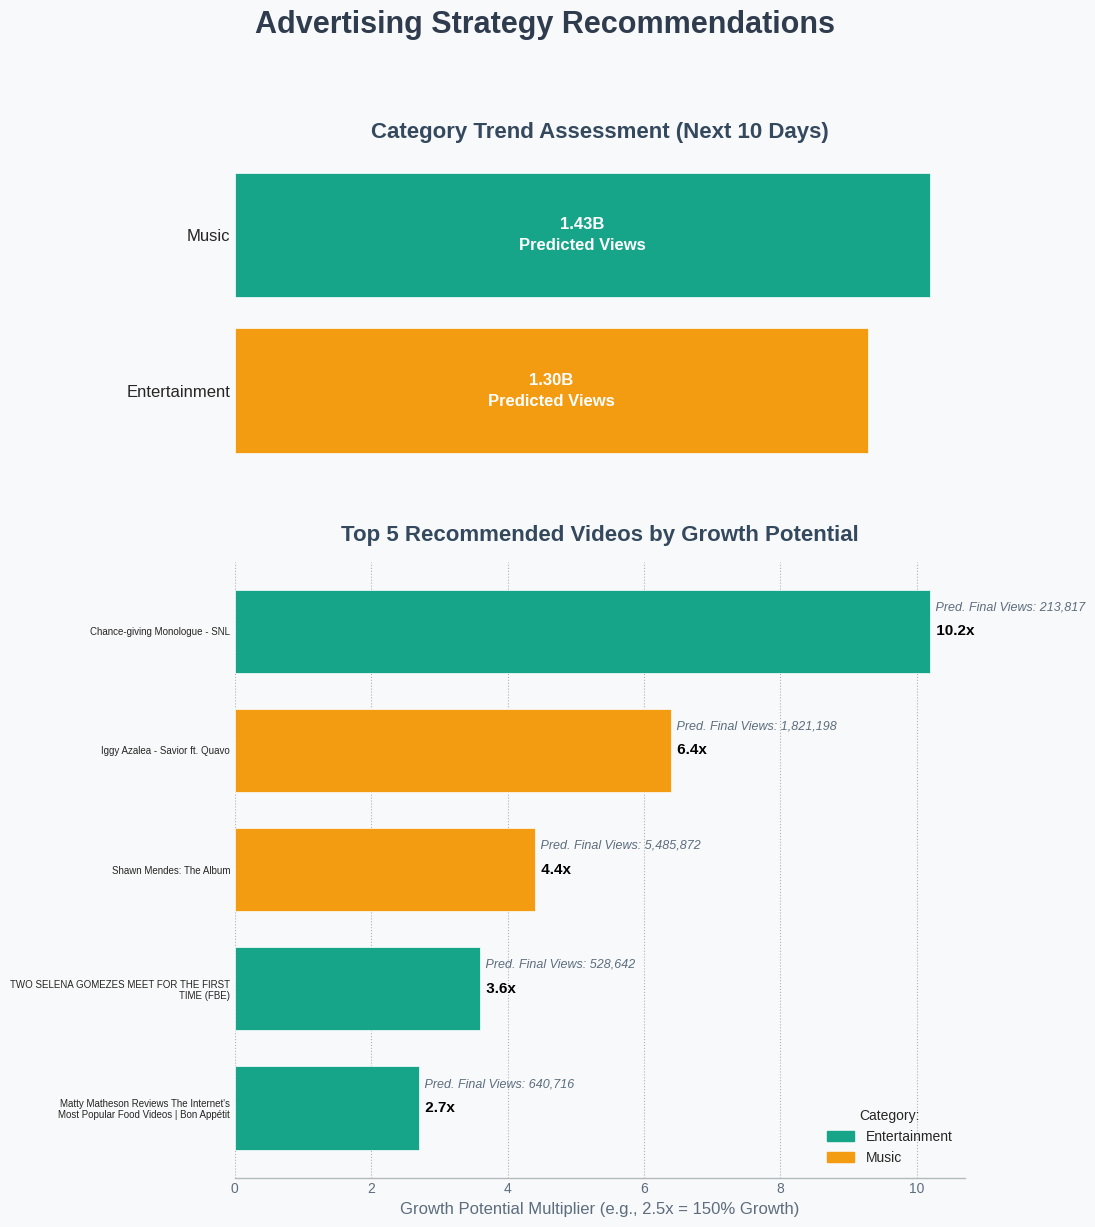

In [ ]:
# Visualization
# 1. Parse the input data
input_data = """
=== Category Trend Assessment ===
- Music: 1,431,235,712 predicted views (next 10 days)
- Entertainment: 1,302,328,320 predicted views (next 10 days)

Found 367 candidate videos in top categories
Authentic videos: 347 (20 removed)


=== Top Video Recommendations ===
Selected 5 videos with highest growth potential:


Video: Chance-giving Monologue - SNL...
- Video ID: jGyUVyp9w9g
- Category: Entertainment
- Current Views: 21,046
- Predicted Final Views: 213,817
- Growth Potential: 10.2x
- Engagement: 7.49% (Likes: 1,308)


Video: Iggy Azalea - Savior ft. Quavo...
- Video ID: T3hXC5yNZOc
- Category: Music
- Current Views: 285,984
- Predicted Final Views: 1,821,198
- Growth Potential: 6.4x
- Engagement: 13.98% (Likes: 34,129)


Video: Shawn Mendes: The Album...
- Video ID: vyqCSzFZyXg
- Category: Music
- Current Views: 799,742
- Predicted Final Views: 5,485,872
- Growth Potential: 4.4x
- Engagement: 9.36% (Likes: 73,491)


Video: TWO SELENA GOMEZES MEET FOR THE FIRST TIME (FBE)...
- Video ID: wTiDluJ4Yd0
- Category: Entertainment
- Current Views: 146,812
- Predicted Final Views: 528,642
- Growth Potential: 3.6x
- Engagement: 5.56% (Likes: 5,936)


Video: Matty Matheson Reviews The Internet's Most Popular Food Videos | Bon Appétit...
- Video ID: 67LnlgA_Too
- Category: Entertainment
- Current Views: 235,830
- Predicted Final Views: 640,716
- Growth Potential: 2.7x
- Engagement: 4.43% (Likes: 9,376)
"""

# Parse Category Trend
lines = input_data.strip().split('\n')
category_data = {}
for line in lines:
    if "predicted views" in line:
        parts = line.split(':')
        category = parts[0].strip().replace('-', '').strip()
        views = int(parts[1].split(' ')[1].replace(',', ''))
        category_data[category] = views

# Parse Top Video Recommendations
video_blocks = input_data.split('Video: ')[1:]
videos_data = []
for block in video_blocks:
    video_info = {}
    lines = block.strip().split('\n')
    video_info['Title'] = lines[0].strip().replace('...','')
    for line in lines[1:]:
        if ':' in line:
            key, value = line.split(':', 1)
            video_info[key.strip().replace('- ', '')] = value.strip()
    videos_data.append(video_info)


# 2. Create visualizations
plt.style.use('seaborn-v0_8-whitegrid')
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(11, 13), gridspec_kw={'height_ratios': [1, 2]})
fig.patch.set_facecolor('#F8F9FA')

fig.suptitle('Advertising Strategy Recommendations', fontsize=22, fontweight='bold', y=0.97, color='#2F3C4E')

fig.subplots_adjust(hspace=120)


# Subplot 1: Category Trend Assessment
ax1.set_facecolor('#F8F9FA')
categories = list(category_data.keys())
predicted_views = list(category_data.values())

colors1 = ['#17A589', '#F39C12']

bars1 = ax1.barh(categories, predicted_views, color=colors1, edgecolor='white', linewidth=0.5, height=0.8)
ax1.set_title('Category Trend Assessment (Next 10 Days)', fontsize=16, fontweight='bold', pad=15, color='#34495E')
ax1.set_xticks([])
ax1.invert_yaxis()
ax1.grid(False)

# Remove all spines
for spine in ax1.spines.values():
    spine.set_visible(False)
ax1.tick_params(axis='y', length=0, labelsize=12)

# Add labels to the bars
for bar in bars1:
    width = bar.get_width()
    label_x_pos = width / 2
    ax1.text(label_x_pos, bar.get_y() + bar.get_height()/2,
             f'{width/1e9:.2f}B\nPredicted Views',
             va='center', ha='center', color='white', fontsize=12, fontweight='bold',
             linespacing=1.5)


# Subplot 2: Top 5 Recommended Videos
ax2.set_facecolor('#F8F9FA')
video_titles = [v['Title'] for v in videos_data]
growth_potentials = [float(v['Growth Potential'].replace('x', '')) for v in videos_data]
video_categories = [v['Category'] for v in videos_data]
predicted_views_videos = [v['Predicted Final Views'] for v in videos_data]

# Wrap long titles
wrapped_titles = [textwrap.fill(title, 40) for title in video_titles]

category_colors = {'Entertainment': '#17A589', 'Music': '#F39C12'}
colors2 = [category_colors.get(cat, '#B2BABB') for cat in video_categories]

bars2 = ax2.barh(wrapped_titles, growth_potentials, color=colors2, height=0.7, edgecolor='white', linewidth=0.5)
ax2.set_title('Top 5 Recommended Videos by Growth Potential', fontsize=16, fontweight='bold', pad=15, color='#34495E')
ax2.set_xlabel('Growth Potential Multiplier (e.g., 2.5x = 150% Growth)', fontsize=12, color='#5D6D7E')
ax2.invert_yaxis()
ax2.tick_params(axis='y', length=0, labelsize=7)
ax2.tick_params(axis='x', colors='#5D6D7E')

ax2.grid(axis='x', linestyle=':', color='grey', alpha=0.6)
ax2.grid(axis='y', visible=False)
for spine_pos in ['top', 'right', 'left']:
    ax2.spines[spine_pos].set_visible(False)
ax2.spines['bottom'].set_color('#B2BABB')


# Add annotations
for i, bar in enumerate(bars2):
    width = bar.get_width()
    pred_views_str = f"Pred. Final Views: {int(predicted_views_videos[i].replace(',', '')):,.0f}"
    ax2.text(width + 0.03, bar.get_y() + bar.get_height()/2,
             f' {width:.1f}x',
             va='center', ha='left', fontsize=11, fontweight='bold', color='black')
    ax2.text(width + 0.03, bar.get_y() + bar.get_height()/2 - 0.25,
             f' {pred_views_str}',
             va='top', ha='left', fontsize=9, style='italic', color='#5D6D7E')

# Add a custom legend
legend_patches = [mpatches.Patch(color=color, label=label) for label, color in category_colors.items()]
ax2.legend(handles=legend_patches, frameon=False, loc='lower right', title='Category:')

fig.tight_layout(rect=[0, 0.03, 1, 0.93])
plt.show()